In [1]:
import matplotlib.pyplot as plt


from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.models import predict
import pandas as pd
import numpy as np

import statistics
from scipy.ndimage import gaussian_filter1d
import math

In [2]:
def load_dataset(name):
    triple_data = open(name).read().strip()
    data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'
    triple = []
    for t in data:
        t[2] = ' '.join(t[2:])
        t = t[:3]
        triple.append(t)
    triple = np.array(triple)
    tf_data = TriplesFactory.from_labeled_triples(triples=triple)
    return tf_data, triple


def create_model(tf_training, tf_testing, embedding, n_epoch, training_loops, path):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,  # 'TransE',  #'RotatE'
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='cpu',
        
        training_loop=training_loops,
        #negative_sampler='basic', #'bernoulli', 'basic',
        
        #negative_sampler_kwargs=dict(
        #filtered=True,
        #filterer='bloom',
        #filterer_kwargs=dict(
        #    error_rate=0.0001,
        #)),
    )
    model = results.model
    results.save_to_directory(path + embedding)
    return model, results



def filter_prediction(predicted_heads_df, constraint):
    predicted_heads_df = predicted_heads_df[predicted_heads_df.head_label.str.contains(constraint)]
    predicted_heads_df = reset_index(predicted_heads_df)
    return predicted_heads_df


def filter_by_type(predicted_heads, triple_data, entity_type):
    list_entity = predicted_heads.head_label
    entity = []
    for s in list_entity:
        for triple in triple_data:
            b = [s, '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', entity_type] == triple
            if np.all(b):
                entity.append(s)
                break
    predicted_heads = predicted_heads.loc[predicted_heads.head_label.isin(entity)]
    predicted_heads = reset_index(predicted_heads)
    return predicted_heads, entity


def get_threshold(predicted_heads, percentile):
    score_values = predicted_heads.score.values
    threshold = np.percentile(score_values, percentile)
    threshold_index = predicted_heads.loc[predicted_heads.score > threshold].shape[0]
    print(threshold, threshold_index)
    return threshold, threshold_index


def get_inflection_point(score_values):
    # standard deviation
    stdev = statistics.stdev(score_values)
    # smooth
    smooth = gaussian_filter1d(score_values, stdev)
    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))
    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    if len(infls) == 1:
        return infls[0]
    if len(infls) == 0:
        return len(score_values)
    # middle inflection point
    m_infls = infls[math.ceil(len(infls) / 2)]
    return m_infls


def get_precision(predicted_heads, inflection_index):
    tp_fp = predicted_heads.iloc[0:inflection_index + 1]
    tp = tp_fp.loc[tp_fp.in_training == True].shape[0]
    prec = tp / tp_fp.shape[0]
    return prec, tp


def get_recall(predicted_heads, tp):
    tp_fn = predicted_heads.loc[predicted_heads.in_training == True].shape[0]
    rec = tp / tp_fn
    return rec


def get_f_measure(precision, recall):
    f_measure = 2 * (precision * recall) / (precision + recall)
    return f_measure


def reset_index(predicted_heads):
    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def compute_metrics(predicted_heads, cut_index):
    precision, tp = get_precision(predicted_heads, cut_index)
    recall = get_recall(predicted_heads, tp)
    f_measure = get_f_measure(precision, recall)
    return pd.DataFrame(columns=['precision', 'recall', 'f_measure'],
                        data=[[precision,recall,f_measure]], index=['MuRe'])


def plot_score_value(score_values, title):
    plt.plot(score_values)
    plt.xlabel("Entities")
    plt.ylabel("Score")
    plt.title(title)
    plt.show()

#### Load dataset I4.0 KG

In [17]:
tf_data, triple_data = load_dataset('sto-enriched-relatedTo.nt')
print('The first two triples:\n', triple_data[:2])
tf_data

/tmp/ipykernel_10238/2177693796.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'


The first two triples:
 [['<http://www.w3.org/1999/02/22-rdf-syntax-ns#value>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2002/07/owl#AnnotationProperty>']
 ['<http://www.w3.org/2001/XMLSchema#gYear>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2000/01/rdf-schema#Datatype>']]


TriplesFactory(num_entities=8947, num_relations=107, num_triples=43475, inverse_triples=False)

### Create training and testing set

In [18]:
training, testing = tf_data.split(random_state=1234)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [26113, 8695]


### Buildind the model

In [19]:
model, results = create_model(training, testing, 'TransR', 10, 'sLCWA', 'results_I4.0/')

Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/8.70k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.83s seconds


In [12]:
results.save_to_directory('results_I4.0/TransR', pickle_protocol=4)

In [16]:
import torch



model_name='MuRE'
print('results_I4.0/LCWA/' + model_name + '/trained_model.pkl')
model_lcwa = torch.load('results_I4.0/LCWA/' + model_name + '/trained_model.pkl')

torch.save(model_lcwa, 'trained_model.pkl', pickle_protocol=4)

results_I4.0/LCWA/MuRE/trained_model.pkl


In [10]:
results.metric_results.to_df().to_csv('results_I4.0/LCWA/TransR/metric_results.csv', index=None)

### Evaluating the Results

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

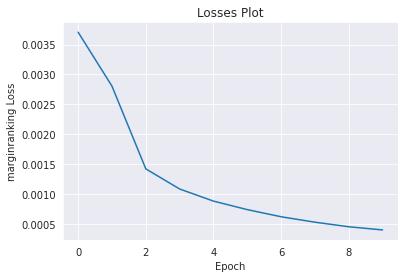

In [20]:
results.plot_losses()

- adjusted mean rank is between [0, 2]. Lower is better.
- mean rank is a positive integer, with a bound based on the number of entities. Lower is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Higher is better!

In [21]:
metrics = results.metric_results.to_df()
print('Side:', metrics.Side.unique(), '\nType:', metrics.Type.unique())
metrics.loc[(metrics.Side=='both') & (metrics.Type=='realistic')]

Side: ['head' 'both' 'tail'] 
Type: ['realistic' 'pessimistic' 'optimistic']


,Side,Type,Metric,Value
47,both,realistic,hits_at_1,6.749281e-01
48,both,realistic,hits_at_3,7.060380e-01
49,both,realistic,hits_at_5,7.198965e-01
50,both,realistic,hits_at_10,7.415756e-01
51,both,realistic,arithmetic_mean_rank,2.665153e+02
52,both,realistic,geometric_mean_rank,4.468025e+00
53,both,realistic,median_rank,1.000000e+00
54,both,realistic,harmonic_mean_rank,1.431882e+00
55,both,realistic,inverse_arithmetic_mean_rank,3.752130e-03
56,both,realistic,inverse_geometric_mean_rank,2.238125e-01


## Link Prediction

The predictions are ordered by their scores.
All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

### Predict links (Head prediction)

In [22]:
#e1 = '<https://w3id.org/i40/sto#hasClassification>'
#e2 = '<https://w3id.org/i40/rami#Safety>'
e1 = '<https://w3id.org/i40/sto#relatedTo>'
e2 = '<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>'
predicted_heads = predict.get_head_prediction_df(model, e1, e2, triples_factory=tf_data)
predicted_heads

,head_id,head_label,score,in_training
6992,6992,<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>,-0.000054,True
7119,7119,<https://w3id.org/i40/sto#ISO_10303>,-0.001565,True
7298,7298,<https://w3id.org/i40/sto#NIST_800-144>,-0.001943,True
6518,6518,<https://w3id.org/i40/sto#DIN_EN_ISO_13849>,-0.002275,True
6988,6988,<https://w3id.org/i40/sto#IEC_61850_P7_S1_E1>,-0.002287,True
...,...,...,...,...
731,731,"""Context Awareness""@en",-3.890358,False
2346,2346,"""Plant Manager""@en",-3.906176,False
6043,6043,<http://yago-knowledge.org/resource/Real-time_...,-3.910952,False
2997,2997,"""The node view is the lowest level view we cur...",-3.918533,False


### Filter the prediction by the head 'sto'

In [58]:
predicted_heads = filter_prediction(predicted_heads, '<https://w3id.org/i40/sto#')
predicted_heads

/home/rivas/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,head_id,head_label,score,in_training
0,6992,<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>,-0.000054,True
1,7119,<https://w3id.org/i40/sto#ISO_10303>,-0.001565,True
2,7298,<https://w3id.org/i40/sto#NIST_800-144>,-0.001943,True
3,6518,<https://w3id.org/i40/sto#DIN_EN_ISO_13849>,-0.002275,True
4,6988,<https://w3id.org/i40/sto#IEC_61850_P7_S1_E1>,-0.002287,True
...,...,...,...,...
1294,6707,<https://w3id.org/i40/sto#FileSizeIEC_61334_P3...,-3.417368,False
1295,7595,<https://w3id.org/i40/sto#VirtualEntities>,-3.453342,False
1296,7191,<https://w3id.org/i40/sto#IicfConnectivityLaye...,-3.455329,False
1297,7400,<https://w3id.org/i40/sto#PlantManager>,-3.597320,False


### Filter by entity type 'Standard'. (it take some minutes)

In [ ]:
predicted_heads, entity = filter_by_type(predicted_heads, triple_data, '<https://w3id.org/i40/sto#Standard>')
predicted_heads

### Plot of entities predicted score values

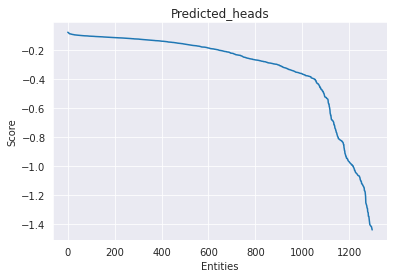

In [74]:
score_values = predicted_heads.score.values
plt.plot(score_values)
plt.xlabel("Entities")
plt.ylabel("Score")
plt.title("Predicted_heads")
plt.show()

### Strategy 'inflection point'

In [75]:
inflection_index = get_inflection_point(predicted_heads.score.values)
compute_metrics(predicted_heads, inflection_index)

ZeroDivisionError: float division by zero

### Strategy 'threshold'

In [65]:
threshold, threshold_index = get_threshold(predicted_heads, 90)
compute_metrics(predicted_heads, threshold_index)

-0.16518535614013666 130


ZeroDivisionError: float division by zero

# Save Learned Embeddings

In [23]:
from typing import List
import pykeen.nn
entity_representation_modules: List['pykeen.nn.RepresentationModule'] = model.entity_representations
relation_representation_modules: List['pykeen.nn.RepresentationModule'] = model.relation_representations

In [24]:
entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]
entity_embeddings

Embedding(
  (_embeddings): Embedding(8947, 50)
)

In [25]:
entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
relation_embedding_tensor: torch.FloatTensor = relation_embeddings()
entity_embedding_tensor

tensor([[ 0.0807,  0.1478, -0.0575,  ...,  0.0347, -0.2499,  0.1882],
        [-0.2874,  0.1005,  0.0375,  ..., -0.0860, -0.0416, -0.2357],
        [-0.1390,  0.1656, -0.0611,  ...,  0.0608, -0.1201,  0.0198],
        ...,
        [-0.2099,  0.1242,  0.2233,  ...,  0.0208, -0.0699,  0.0770],
        [-0.3075, -0.0893,  0.1007,  ..., -0.2333, -0.2401,  0.0747],
        [-0.1497,  0.0662,  0.1372,  ..., -0.2134,  0.1606,  0.0636]],
       grad_fn=<ViewBackward>)

In [44]:
type(entity_embedding_tensor[0].detach().numpy())

numpy.ndarray

In [49]:
list(predicted_heads.head_label)

['<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>',
 '<https://w3id.org/i40/sto#ISO_10303>',
 '<https://w3id.org/i40/sto#NIST_800-144>',
 '<https://w3id.org/i40/sto#DIN_EN_ISO_13849>',
 '<https://w3id.org/i40/sto#IEC_61850_P7_S1_E1>',
 '<https://w3id.org/i40/sto#IEC_61850_P10_E2>',
 '<https://w3id.org/i40/sto#IEC_29100>',
 '<https://w3id.org/i40/sto#DIN_SPEC_16592>',
 '<https://w3id.org/i40/sto#ODRL>',
 '<https://w3id.org/i40/sto#IEC_27036>',
 '<https://w3id.org/i40/sto#ISO_27001>',
 '<https://w3id.org/i40/sto#RFC_2616>',
 '<https://w3id.org/i40/sto#NIST_800-146>',
 '<https://w3id.org/i40/sto#ISO_14306>',
 '<https://w3id.org/i40/sto#RFC_793>',
 '<https://w3id.org/i40/sto#IEC_61850_P4_E2>',
 '<https://w3id.org/i40/sto#IEC_62890>',
 '<https://w3id.org/i40/sto#OMG_DDS>',
 '<https://w3id.org/i40/sto#IEC_61508>',
 '<https://w3id.org/i40/sto#IEC_29182_P1>',
 '<https://w3id.org/i40/sto#IEC_24760>',
 '<https://w3id.org/i40/sto#ISO_22745-11>',
 '<https://w3id.org/i40/sto#IEC_61804>',
 '<https://w

In [56]:
df = pd.DataFrame(entity_embedding_tensor.detach().numpy())
df['target']=list(training.entity_to_id)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,0.080726,0.147822,-0.057531,-0.018866,-0.005884,-0.066989,-0.009268,-0.196573,0.218556,0.047298,...,-0.059657,0.094147,-0.140624,0.095575,0.098733,-0.179553,0.03471,-0.249917,0.188194,""" - IEEE Standard for Ubiquitous Green Communi..."
1,-0.287366,0.100504,0.037514,0.045899,-0.035416,0.216882,0.170573,-0.112416,0.144684,0.160309,...,-0.071803,-0.056839,0.101880,0.043932,0.196416,0.190132,-0.08602,-0.041644,-0.235655,""" A business manager is responsible for the ru..."


In [70]:
new_df = df.loc[df.target.isin(list(predicted_heads.head_label))]
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
6392,-0.029416,0.052457,0.182691,-0.123825,0.230591,-0.108407,0.020409,0.217041,-0.088204,0.132000,...,-0.092559,-0.080356,-0.000724,-0.085026,-0.156694,-0.146074,-0.239976,-0.261420,-0.195400,<https://w3id.org/i40/sto#>
6393,-0.245019,-0.234796,-0.294709,-0.156903,0.136166,0.140796,0.050698,0.059236,-0.125283,0.179715,...,-0.219200,0.117132,0.002455,0.056450,0.011452,0.080722,0.038436,0.053894,0.034317,<https://w3id.org/i40/sto#AI>
6394,0.104705,-0.176745,0.022682,-0.113196,0.216931,0.065034,-0.153694,0.139133,-0.201178,0.065818,...,0.100799,0.012150,0.125947,0.156517,-0.189259,0.063992,0.170351,0.000906,0.208601,<https://w3id.org/i40/sto#AMQP>
6395,0.166747,-0.165308,-0.050237,0.074934,-0.033325,-0.301182,0.125626,0.146608,-0.087366,-0.113248,...,0.039924,0.202212,-0.188809,0.240911,-0.085204,0.026195,-0.036326,-0.012624,0.061233,<https://w3id.org/i40/sto#ANSI>
6396,0.208218,0.163593,-0.266470,0.073799,0.235692,-0.138780,-0.002179,-0.177738,-0.029449,-0.012398,...,-0.080487,-0.170807,-0.130568,0.115966,0.130391,-0.213527,0.215656,0.198617,0.025585,<https://w3id.org/i40/sto#ANT>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,0.176372,-0.146131,-0.156244,0.053698,-0.144817,0.198972,-0.035326,-0.121870,-0.211996,-0.113361,...,0.080229,-0.256325,0.261444,-0.202688,0.098059,0.092471,0.102193,0.095201,-0.182912,<https://w3id.org/i40/sto#xRoadSystemComponents>
7687,0.148549,-0.227487,0.021946,-0.111999,-0.071693,0.157763,0.074941,0.294583,-0.089174,0.136051,...,0.038905,0.099696,0.171554,-0.004377,0.191543,-0.009587,0.010909,-0.270928,-0.223658,<https://w3id.org/i40/sto#xRoadSystemComponent...
7688,-0.139303,-0.009196,-0.054107,0.247741,0.072196,-0.076516,-0.162518,0.165614,0.007628,0.010619,...,0.195405,-0.098445,-0.196496,-0.139053,0.077373,0.048382,0.009023,0.135670,-0.231860,<https://w3id.org/i40/sto#xRoadTechnologyMatrix>
7689,0.014606,-0.068748,0.099749,-0.195735,-0.089951,0.078330,-0.180757,-0.060392,0.023724,-0.045675,...,-0.020024,0.107139,0.273314,0.006676,-0.168823,-0.271418,0.007965,0.032351,-0.039946,<https://w3id.org/i40/sto#xRoadTechnologyMatri...


In [71]:
new_df = new_df.iloc[: , :-1]
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
6392,-0.029416,0.052457,0.182691,-0.123825,0.230591,-0.108407,0.020409,0.217041,-0.088204,0.132000,...,0.163387,-0.092559,-0.080356,-0.000724,-0.085026,-0.156694,-0.146074,-0.239976,-0.261420,-0.195400
6393,-0.245019,-0.234796,-0.294709,-0.156903,0.136166,0.140796,0.050698,0.059236,-0.125283,0.179715,...,0.144264,-0.219200,0.117132,0.002455,0.056450,0.011452,0.080722,0.038436,0.053894,0.034317
6394,0.104705,-0.176745,0.022682,-0.113196,0.216931,0.065034,-0.153694,0.139133,-0.201178,0.065818,...,-0.111998,0.100799,0.012150,0.125947,0.156517,-0.189259,0.063992,0.170351,0.000906,0.208601
6395,0.166747,-0.165308,-0.050237,0.074934,-0.033325,-0.301182,0.125626,0.146608,-0.087366,-0.113248,...,-0.044661,0.039924,0.202212,-0.188809,0.240911,-0.085204,0.026195,-0.036326,-0.012624,0.061233
6396,0.208218,0.163593,-0.266470,0.073799,0.235692,-0.138780,-0.002179,-0.177738,-0.029449,-0.012398,...,-0.031966,-0.080487,-0.170807,-0.130568,0.115966,0.130391,-0.213527,0.215656,0.198617,0.025585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,0.176372,-0.146131,-0.156244,0.053698,-0.144817,0.198972,-0.035326,-0.121870,-0.211996,-0.113361,...,-0.223444,0.080229,-0.256325,0.261444,-0.202688,0.098059,0.092471,0.102193,0.095201,-0.182912
7687,0.148549,-0.227487,0.021946,-0.111999,-0.071693,0.157763,0.074941,0.294583,-0.089174,0.136051,...,-0.086976,0.038905,0.099696,0.171554,-0.004377,0.191543,-0.009587,0.010909,-0.270928,-0.223658
7688,-0.139303,-0.009196,-0.054107,0.247741,0.072196,-0.076516,-0.162518,0.165614,0.007628,0.010619,...,0.046485,0.195405,-0.098445,-0.196496,-0.139053,0.077373,0.048382,0.009023,0.135670,-0.231860
7689,0.014606,-0.068748,0.099749,-0.195735,-0.089951,0.078330,-0.180757,-0.060392,0.023724,-0.045675,...,-0.043147,-0.020024,0.107139,0.273314,0.006676,-0.168823,-0.271418,0.007965,0.032351,-0.039946


In [73]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def call_KMeans(cosine_matrix):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 5))
    visualizer.fit(cosine_matrix)
    num_cls = visualizer.elbow_value_
    #visualizer.show()
    #print(num_cls, type(num_cls))
    kmeans = KMeans(n_clusters=num_cls, init ='k-means++', max_iter=300, n_init=10,random_state=0).fit(cosine_matrix)  
    return kmeans, num_cls

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fa84bec1820>
Traceback (most recent call last):
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 548, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 669, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 786, in __init__
    super().__init__(**kwargs)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 754, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/rivas/.local/lib/python3.8/site-packages/numpy.libs/libopenblasp-

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fa84bec1820>
Traceback (most recent call last):
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 548, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 669, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 786, in __init__
    super().__init__(**kwargs)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 754, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/rivas/.local/lib/python3.8/site-packages/numpy.libs/libopenblasp-

TypeError: '<' not supported between instances of 'int' and 'NoneType'

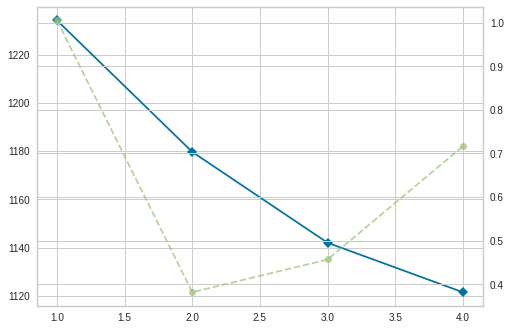

In [74]:
kmeans, num_cls = call_KMeans(new_df)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fa849699e50>
Traceback (most recent call last):
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 548, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 669, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 786, in __init__
    super().__init__(**kwargs)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 754, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/rivas/.local/lib/python3.8/site-packages/numpy.libs/libopenblasp-

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fa8496a1040>
Traceback (most recent call last):
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 548, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 669, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 786, in __init__
    super().__init__(**kwargs)
  File "/home/rivas/.local/lib/python3.8/site-packages/threadpoolctl.py", line 754, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/rivas/.local/lib/python3.8/site-packages/numpy.libs/libopenblasp-

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

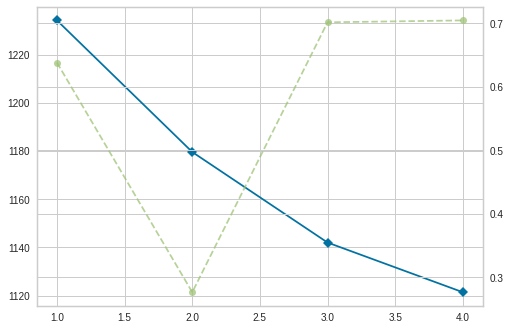

In [78]:
new_df
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 5))
visualizer.fit(new_df)

In [40]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = df
pca = PCA(n_components=2).fit(X)
pca_c = pca.transform(X)
#kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
kmeans = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0).fit(df)
plt.scatter(pca_c[:, 0], pca_c[:, 1], c=kmeans.labels_, alpha = 0.6, s=100, marker='+')   #c=df.c, alpha = 0.6, s=10)
plt.title("Clusters of Standard")

plt.show()


,0,1,2,3,4,5,6,7,8
0,-0.1,-0.29,0.49,0.45,-1.15,-0.27,1.46,0.89,-0.49
1,0.71,0.01,1.41,-1.31,1.57,-0.26,0.44,1.35,1.04
2,-0.56,-0.36,-2.31,1.33,0.88,0.02,1.51,-1.14,0.45
3,0.69,-1.79,-0.25,0.58,-0.75,-2.58,-0.89,-0.17,0.28
4,-0.53,0.0,1.53,-0.36,0.44,-0.38,-0.21,0.01,0.23
5,1.12,0.9,-1.2,0.14,-1.63,-0.38,-0.72,0.46,0.04
6,-0.11,-1.85,0.36,-0.37,0.53,1.32,-1.09,0.19,0.48
7,-0.49,-0.28,-0.45,-0.79,0.01,-0.88,-0.61,0.5,0.27
8,0.32,-0.21,0.31,-1.53,-1.67,-0.34,0.18,-0.08,-1.64
9,1.33,-0.61,-0.99,-1.08,0.2,0.46,0.64,-1.55,0.55


In [30]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)principalComponents = pca.fit_transform(x)

In [47]:
#e1 = '<https://w3id.org/i40/sto#ISO_24760>'
#e1 = '<https://w3id.org/i40/sto#IEC_62541>'
#e1 = '<https://w3id.org/i40/sto#ISO_18629>'
#e1 = '<https://w3id.org/i40/sto#IEC_62237>'
#e1 = '<https://w3id.org/i40/sto#ISO_15746>'
e1 = '<https://w3id.org/i40/sto#ISO_TS_14649-201>'
e2 = '<https://w3id.org/i40/sto#hasClassification>'
predicted_tails = predict.get_tail_prediction_df(model, e1, e2, triples_factory=tf_data)
predicted_tails

,tail_id,tail_label,score,in_training
7183,7183,<https://w3id.org/i40/sto#ISO_TS_14649-201>,-7.499722,False
7440,7440,<https://w3id.org/i40/sto#RAMIEnterprise>,-8.485903,False
1220,1220,"""ICS 01.040.35""@en",-8.673809,False
7438,7438,<https://w3id.org/i40/sto#RAMIControlDevice>,-8.768282,False
7453,7453,<https://w3id.org/i40/sto#RAMIProduct>,-8.774226,True
...,...,...,...,...
3319,3319,<http://cs.dbpedia.org/resource/IBM>,-14.668514,False
3243,3243,"""iShare""@en",-14.682503,False
412,412,"""71""^^<http://www.w3.org/2001/XMLSchema#int>",-14.758469,False
392,392,"""6.9E1""^^<http://www.w3.org/2001/XMLSchema#float>",-14.765898,False


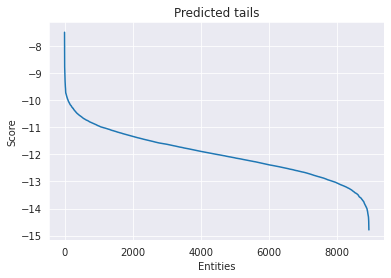

In [48]:
score_values = predicted_tails.score.values
plot_score_value(score_values, "Predicted tails")

In [51]:
predicted_tails = reset_index(predicted_tails)
compute_metrics(predicted_tails, 5)

,precision,recall,f_measure
MuRe,0.166667,0.142857,0.153846
